# Assignment 4.

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Software

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Writing - review & editing

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Visualization, Software, Writing - original draft

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

The objective of this laboratory work is to determine conditions for which broadly used
methods of running and exponential mean provide effective solution and conditions under which
they break down. Important outcome of this exercise is getting skill to choose the most effective
method in conditions of uncertainty.

## Libraries import and necessary functions

In [26]:
import numpy as np
import pandas as pd
from IPython.display import Image
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import minmax_scale

pd.options.plotting.backend = 'plotly'

In [27]:
def run_mean_13month(data: np.ndarray) -> np.ndarray:
    flux = []
    for i in range(6, len(data) - 6):
        flux.append((data[i-6] + data[i+6])/24 + data[i-5:i+5].sum()/12)
    flux_ = list(data[:6]) + list(flux) + list(data[-6:])
    return np.array(flux_)

def running_mean_edgy(data: np.ndarray, window_size: int) -> np.ndarray:
    """Implementation of 'mirror' edge behaviour for running mean"""
    data_ = list(data)
    data_filtered_ext = np.array(data_[1:window_size//2 + 1][::-1] + data_ + data_[-window_size//2:-1][::-1])
    smoothed_data = []
    for i in range(len(data)):
        smoothed_data.append(sum(data_filtered_ext[i:i+window_size])/window_size)
    return np.array(smoothed_data)

def exponential_smoothing(data: np.array, alpha: float, backward: bool = False) -> np.array:
    if not 0 < alpha < 1:
        raise ValueError("Alpha must be between 0 and 1.")
    smoothed_values = [data[0]]

    for t in range(1, len(data)):
        smoothed_value = smoothed_values[-1] + alpha * (data[t] - smoothed_values[-1])
        smoothed_values.append(smoothed_value)
    if backward:
        return exponential_smoothing(smoothed_values[::-1], alpha)[::-1]
    else:
        return smoothed_values

def trajectory(sample_size: int = 300, X1: float = 5, V1: float = 0, T: float = 0.1, variance: float = 10) -> np.array:
    '''Generates trajectory
    T is delta T'''
    # initialize values
    a = np.random.normal(0, np.sqrt(variance), sample_size)
    X, V = np.zeros((sample_size,)), np.zeros((sample_size,))
    X[0], V[0] = X1, V1

    # calculate trajectory
    for i in range(1, sample_size):
        V[i] = V[i-1] + a[i-1] * T
        X[i] = X[i-1] + V[i-1] * T + a[i-1]*(T**2)/2
    return X

def indicators(measurements: np.array, smoothed_data: np.array, print_: bool = False) -> (float, float):
    if len(measurements) != len(smoothed_data):
        raise ValueError(f"Unequal lengths of measurements {len(measurements)} and smoothed data {len(smoothed_data)}")
    MSE = ((measurements - smoothed_data)**2).mean()
    second_deriv = []
    for i in range(1, len(measurements) - 1):
        second_deriv.append(smoothed_data[i-1] + smoothed_data[i+1] - 2 * smoothed_data[i])
    Variability_ind = sum([x**2 for x in second_deriv]) / len(measurements)
    if print_:
        return str((f"MSE = {MSE:.1e}, VI = {Variability_ind:.1e}")) 
    else:
        return MSE, Variability_ind

In [28]:
import plotly.io as pio
pio.templates["standard"] = go.layout.Template(layout=dict(
    title_font_family = 'Courier',
    font_size = 20,
    margin = dict(t=50, b=0, l=50, r=0),
    yaxis_nticks = 4,
    xaxis_nticks = 5,
    legend_title = '',
    legend_font_family = 'Courier',
    legend_orientation = 'v',
    legend_xanchor = 'right',
    legend_bgcolor = 'rgba(256,256,256,0.8)',
    legend_x = 1,
    legend_y = 1.15,
    width = 1150, 
    height = 500)
)
colors = px.colors.qualitative.Plotly
pio.templates.default = 'simple_white+standard'

In [29]:
def load_data(name: str) -> (np.ndarray, np.ndarray, np.ndarray):
    """Loads data according to the input name
    Output: x, y, z(if applicable)
    Output_dtype - numpy arrays"""
    names_dict = dict(sunspot = "ass4_data_group6.txt", truesurf = "ass4_true_surface.txt", noisesurf = "ass4_noisy_surface.txt")
    if name not in names_dict.keys():
        raise ValueError(f"There's no such file. Try one of {names_dict.keys()}")
    df = pd.read_csv(names_dict[name], sep="\s+", decimal = ".", header=None)
    if name == 'sunspot':
        df.columns = ["year", "month#", "sunspot_N"]
        df['datetime'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month#'].astype(str), format='%Y-%m')
        return df.datetime.values, df.sunspot_N.values, None
    else:
        return df.index.values, np.array(df.columns.tolist()), df.values

# Part 1

In [30]:
x, y, z = load_data("sunspot")
y_rm = run_mean_13month(y)
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = y, name = "sunspot#", mode= 'markers', 
                         marker_color = colors[0], marker_size = 4))
alphas = [0.125, 0.175, 0.385, 0.2,]
line_widths = [1]*(len(alphas) - 1) + [3]
alpha_colors = px.colors.sample_colorscale("Purp", minmax_scale(alphas + [0.4]))
for alpha, color, lw in zip(alphas, alpha_colors, line_widths):
    y_exp= exponential_smoothing(y, alpha, True)
    fig.add_trace(go.Scatter(x = x, y = y_exp, line_color= color, line_width = lw,
                             name = f"exp smooth \u03b1 = {alpha}\
                                <br>{indicators(y, y_exp, True)}",))
fig.add_trace(go.Scatter(x = x, y = y_rm, 
                         name = f"13 month running mean<br>{indicators(y, y_rm, True)}", 
                         mode= 'lines', line_color = colors[6], line_dash = "dot", line_width = 3))

fig.update_layout(title = "Sunspot#: running mean vs. exp smoothing",
                  xaxis_title = "<b>Date</b>",
                  yaxis_title = "<b>Sunspot</b> #",
                  legend_xanchor = "left", legend_x = 0.01, legend_y = 0.99,
                  legend_font_size = 12,
                  )
fig.show()

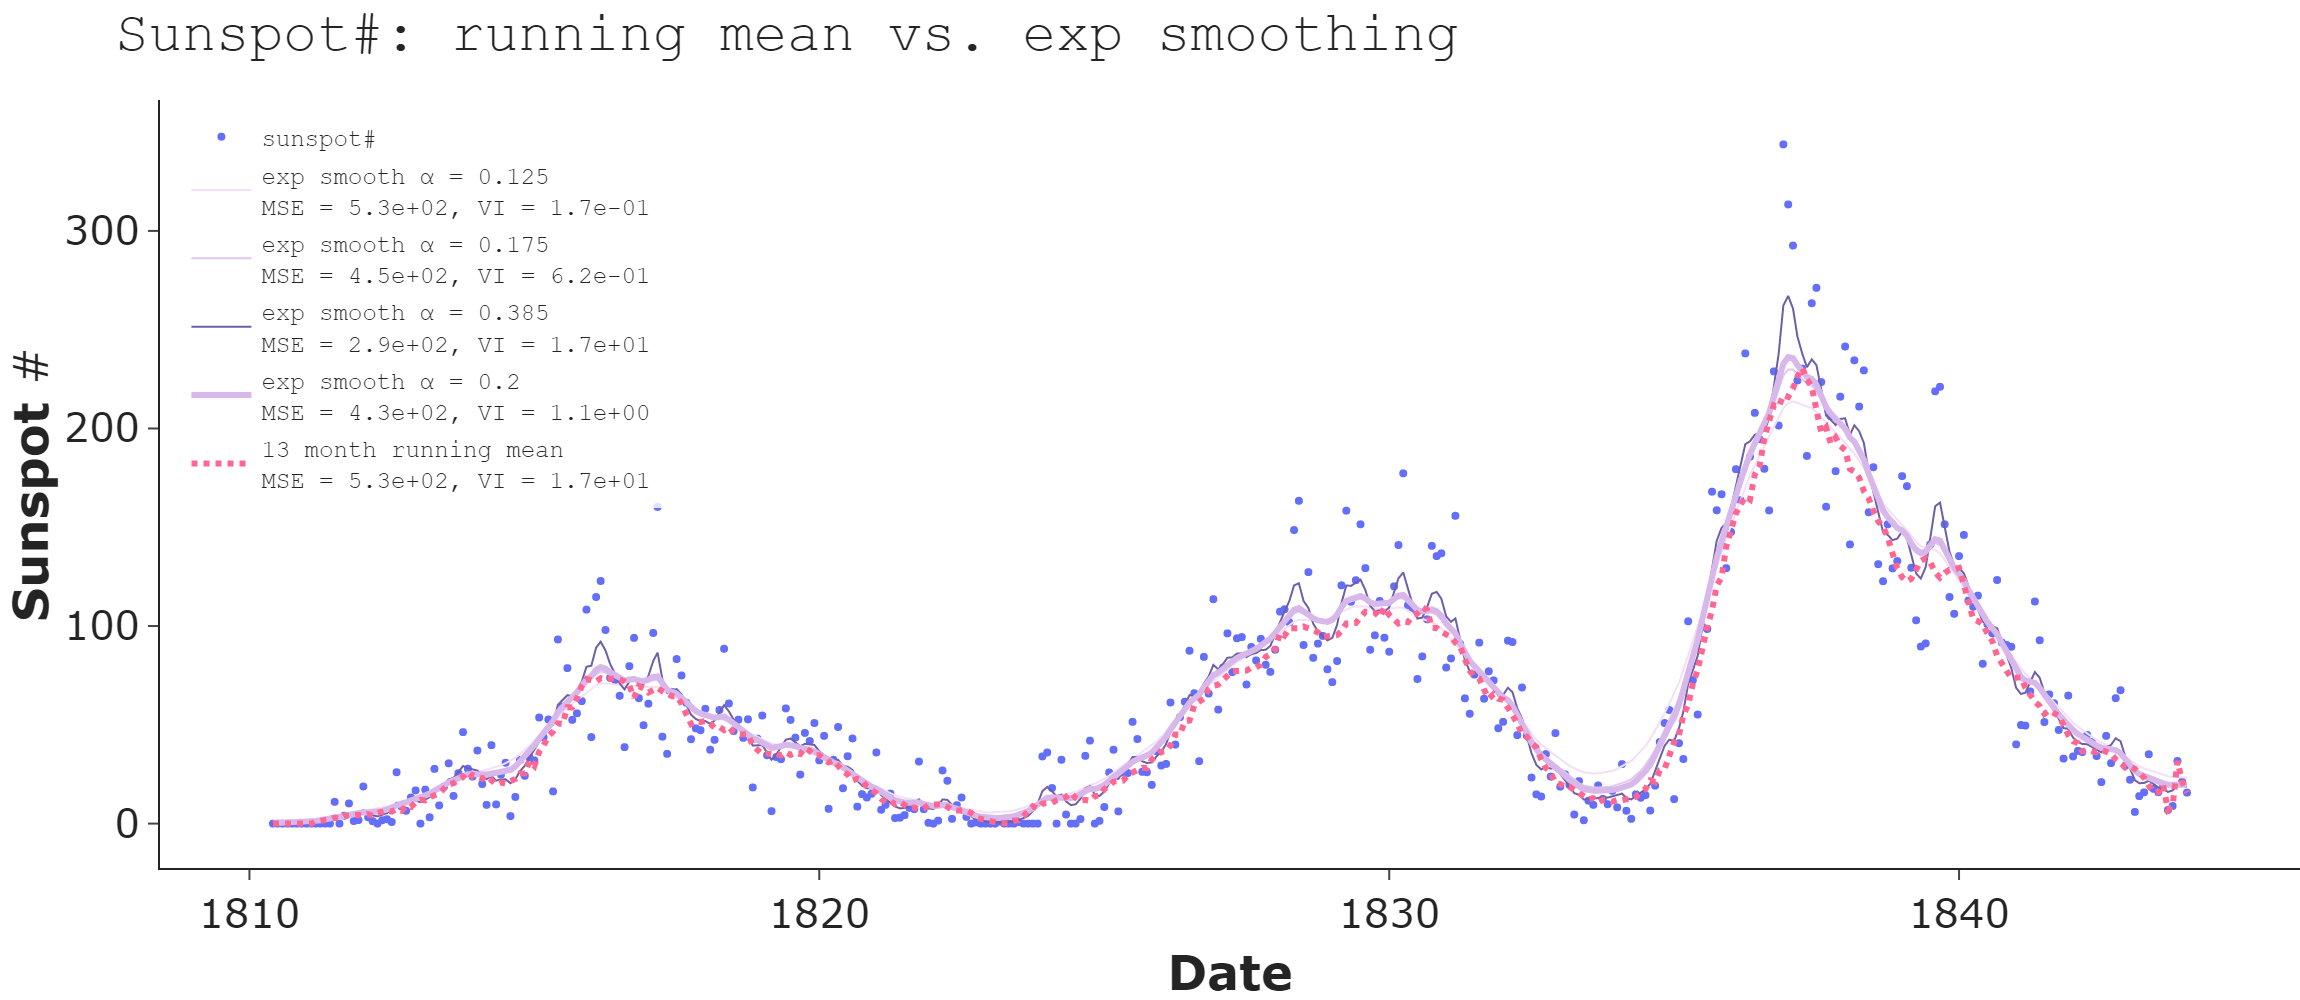

In [31]:
fig.write_image("Sunspot running mean vs. forward-backward smoothing.png", format = "png", scale = 2)
Image("Sunspot running mean vs. forward-backward smoothing.png")

all values of alpha between 0.175 and 0.385 will give MSE and VI values better than the 13 month running mean. <br>
According to our perception of a "nicely looking smooth fit" alpha = 0.2 is the optimal value <br>

## Part II

In [32]:
def exp2d(matrix: np.ndarray, alpha: float =.335) -> np.ndarray:
    smoothed_1D, smoothed_2D = [], []
    smoothed_1D = [exponential_smoothing(matrix[i, :], alpha, backward=True) for i in range(matrix.shape[0])]
    smoothed_2D = [exponential_smoothing(np.array(smoothed_1D)[:, i], alpha, backward=True) for i in range(len(smoothed_1D[0]))]
    return np.array(smoothed_2D).T

In [33]:
def dev_var(noisy_surface: np.ndarray, 
            true_surface: np.ndarray = load_data("truesurf")[2]
            ) -> str:
    """Calculates variance of the deviation of the noisy surface from the true one
returns string to be printed as a subplot title"""
    deviation_variance = ((true_surface - noisy_surface)**2).mean()
    return str(f"<br>\u03c3<sup>2</sup> = {deviation_variance:.2f}")

def rescale(surface: np.ndarray, 
            reference_surface: np.ndarray = load_data("noisesurf")[2]
            ) -> np.ndarray:
    """Performs minmax rescaling of the surface with respect to min and max of the reference surface"""
    min_ref = reference_surface.min()
    max_ref = reference_surface.max()
    
    rescaled_surface = (surface - min_ref) / (max_ref - min_ref)

    return rescaled_surface

def dev_var_norm(noisy_surface: np.ndarray = load_data("noisesurf")[2], 
                 true_surface: np.ndarray = load_data("truesurf")[2]
                 ) -> str:
    """Calculates variance of the deviation of the noisy surface from the true one
returns string to be printed as a subplot title"""
    deviation_variance = ((rescale(true_surface, noisy_surface) \
                           - rescale(noisy_surface, noisy_surface))**2).mean()
    return str(f"<br>\u03c3<sup>2</sup><sub>norm</sub> = {deviation_variance:.2e}")

In [34]:
x1, y1, z1 = load_data("truesurf")
x, y, z = load_data("noisesurf")
zs = exp2d(z)
subplot_titles = (f"Noisy surface{dev_var(z, z1)}", 
                  f"Smoothed surface <br>\u03b1 = .335{dev_var(zs, z1)}", 
                  "True surface")

fig = make_subplots(rows = 1, cols = 3, 
                    subplot_titles = subplot_titles,
                    specs=[[{"type":'surface'}, {"type":'surface'}, {"type":'surface'}]],
                    horizontal_spacing=0.01, vertical_spacing=0.01)
fig.add_trace(go.Surface(x=x1, y=y1, z=rescale(z1,z), showscale= False, opacity=0.15), row=1, col = 1)
fig.add_trace(go.Surface(x=x1, y=y1, z=rescale(z1,z), showscale= False, opacity=0.15), row=1, col = 2)
fig.add_trace(go.Surface(x=x1, y=y1, z=rescale(z1,z), showscale= False, opacity=1), row=1, col = 3)
fig.add_trace(go.Surface(x=x, y=y, z=rescale(zs,z), showscale = False), row=1, col = 2, )
fig.add_trace(go.Surface(x=x, y=y, z=rescale(z,z), showscale = True), row=1, col = 1, )

fig.update_layout(title='', autosize=True,
                  font_size = 15,
                  font_family = 'Courier',
                  scene_xaxis_visible = False,
                  scene_yaxis_visible = False,
                  scene_zaxis_visible = False,
                  scene2_xaxis_visible = False,
                  scene2_yaxis_visible = False,
                  scene2_zaxis_visible = False,
                  scene3_xaxis_visible = False,
                  scene3_yaxis_visible = False,
                  scene3_zaxis_visible = False,
                  margin=dict(l=0, r=0, b=0, t=70))
fig.show()

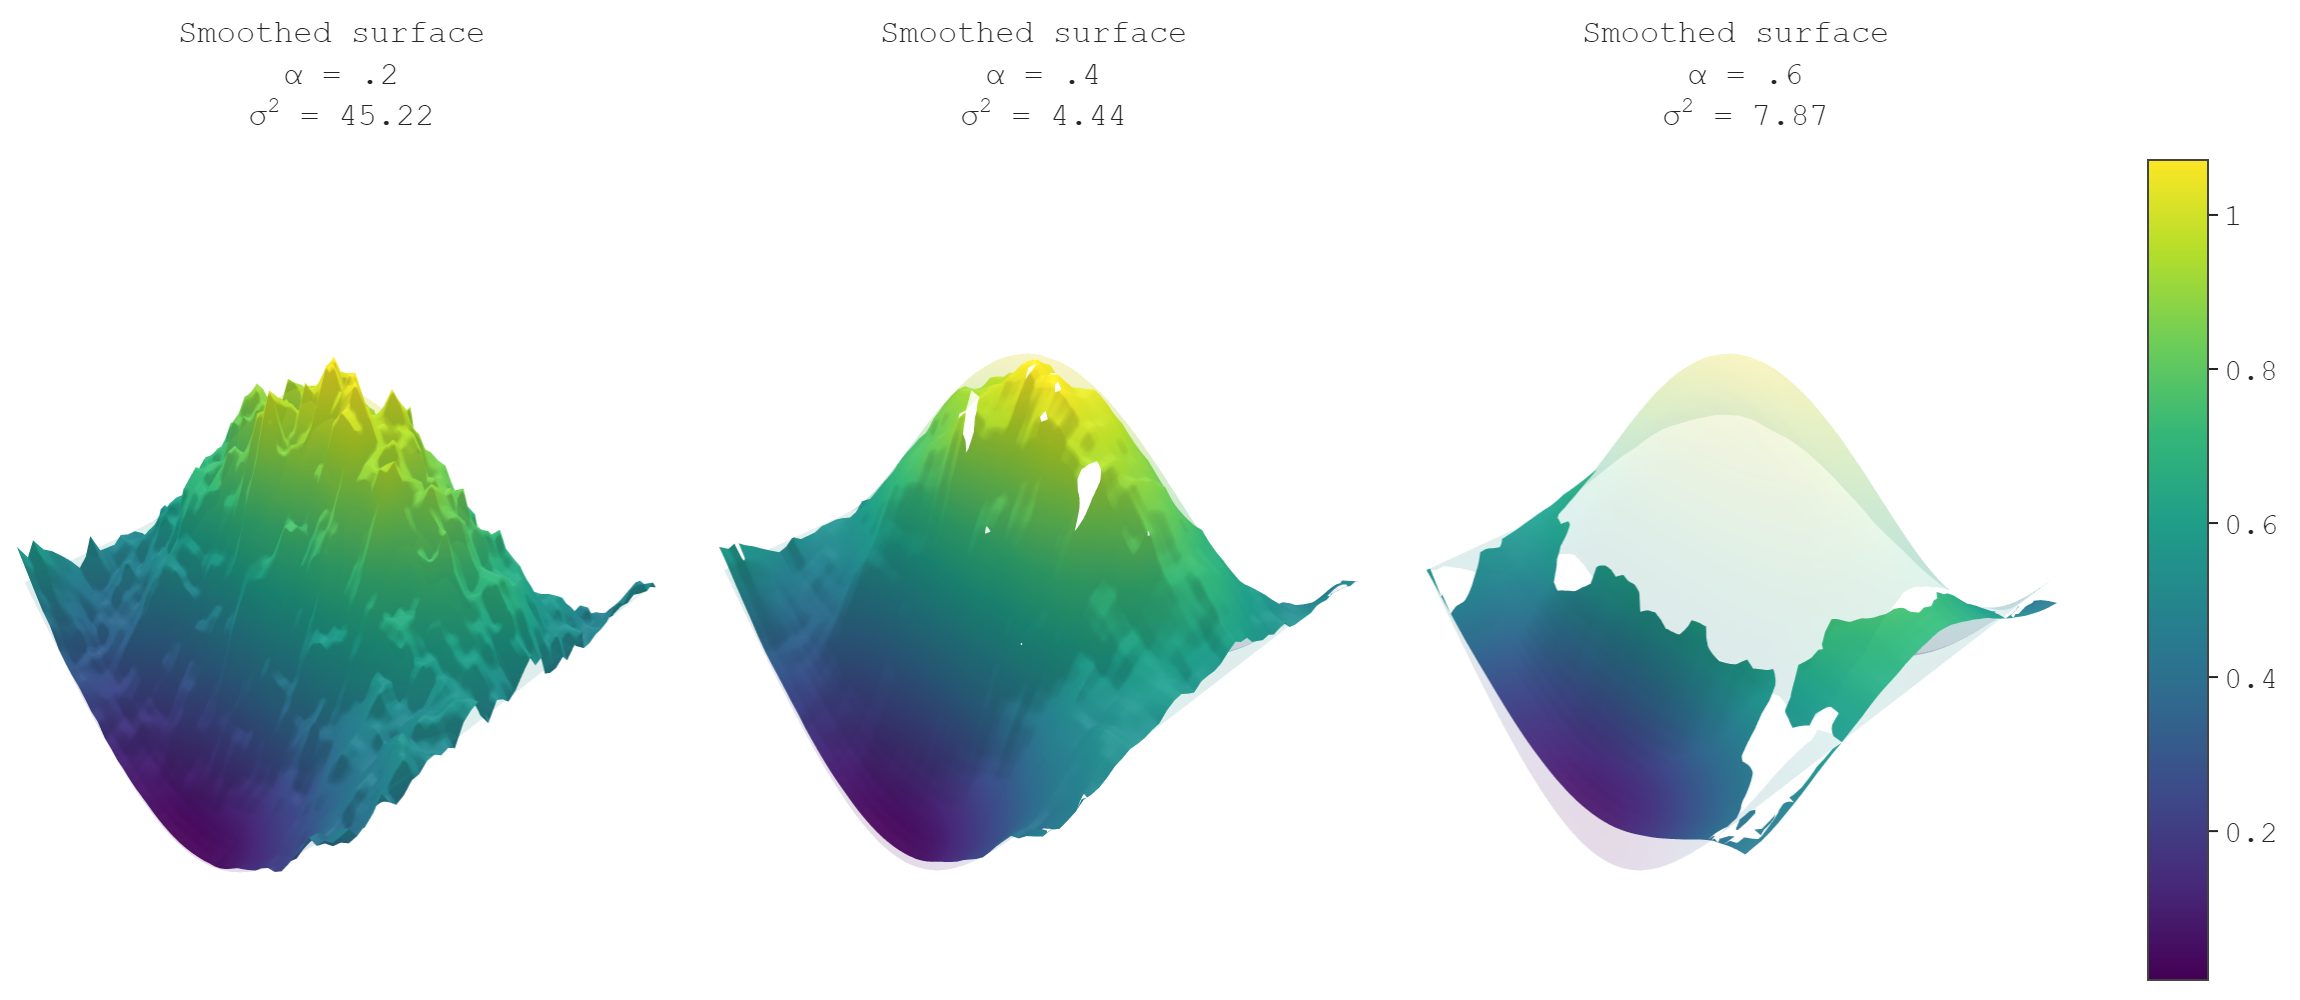

In [44]:
fig.write_html("Surface exp smoothing.html")
fig.write_image("Surface exp smoothing.png", format = 'png', scale = 2)
Image("Surface exp smoothing.png")

True surface is plotted on all graphs with 0.15 opacity<br>
For some reason the static image saving engine (kaleido) gives this strange artifact. <br>
To look at the properly rendered interactive image look at the attached .html file <br>
Also surfaces were normalized in order to display only one colorbar, but printed sigma values are calculated for original data<br>
So numbers on the colorbar are arbitrary <br>

Exponential forward - backward 2D smoothing allows to significantly decrease the variance of deviation of the smoothed surface from the true one

In [36]:
x1, y1, z1 = load_data("truesurf")
x, y, z = load_data("noisesurf")
zs1 = exp2d(z, 0.2)
zs2 = exp2d(z, 0.4)
zs3 = exp2d(z, 0.6)


subplot_titles = (f"Smoothed surface <br>\u03b1 = .2{dev_var(z1, exp2d(z, 0.2))}", 
                  f"Smoothed surface <br>\u03b1 = .4{dev_var(z1, exp2d(z, 0.4))}", 
                  f"Smoothed surface <br>\u03b1 = .6{dev_var(z1, exp2d(z, 0.6))}")

fig = make_subplots(rows = 1, cols = 3, 
                    subplot_titles = subplot_titles,
                    specs=[[{"type":'surface'}, {"type":'surface'}, {"type":'surface'}]],
                    horizontal_spacing=0.01, vertical_spacing=0.01)
fig.add_trace(go.Surface(x=x, y=y, z=rescale(z1,z1), showscale= False, opacity=0.15), row=1, col = 1)
fig.add_trace(go.Surface(x=x, y=y, z=rescale(z1,z1), showscale= False, opacity=0.15), row=1, col = 2)
fig.add_trace(go.Surface(x=x, y=y, z=rescale(z1,z1), showscale= False, opacity=0.15), row=1, col = 3)

fig.add_trace(go.Surface(x=x, y=y, z=rescale(zs1,z1), showscale= False), row=1, col = 3)
fig.add_trace(go.Surface(x=x, y=y, z=rescale(zs2,z1), showscale= False), row=1, col = 2)
fig.add_trace(go.Surface(x=x, y=y, z=rescale(zs3,z1), showscale= True), row=1, col = 1)

fig.update_layout(title='', autosize=True,
                  font_size = 15,
                  font_family = 'Courier',
                  scene_xaxis_visible = False,
                  scene_yaxis_visible = False,
                  scene_zaxis_visible = False,
                  scene2_xaxis_visible = False,
                  scene2_yaxis_visible = False,
                  scene2_zaxis_visible = False,
                  scene3_xaxis_visible = False,
                  scene3_yaxis_visible = False,
                  scene3_zaxis_visible = False,
                  margin=dict(l=0, r=0, b=0, t=70))
fig.show()

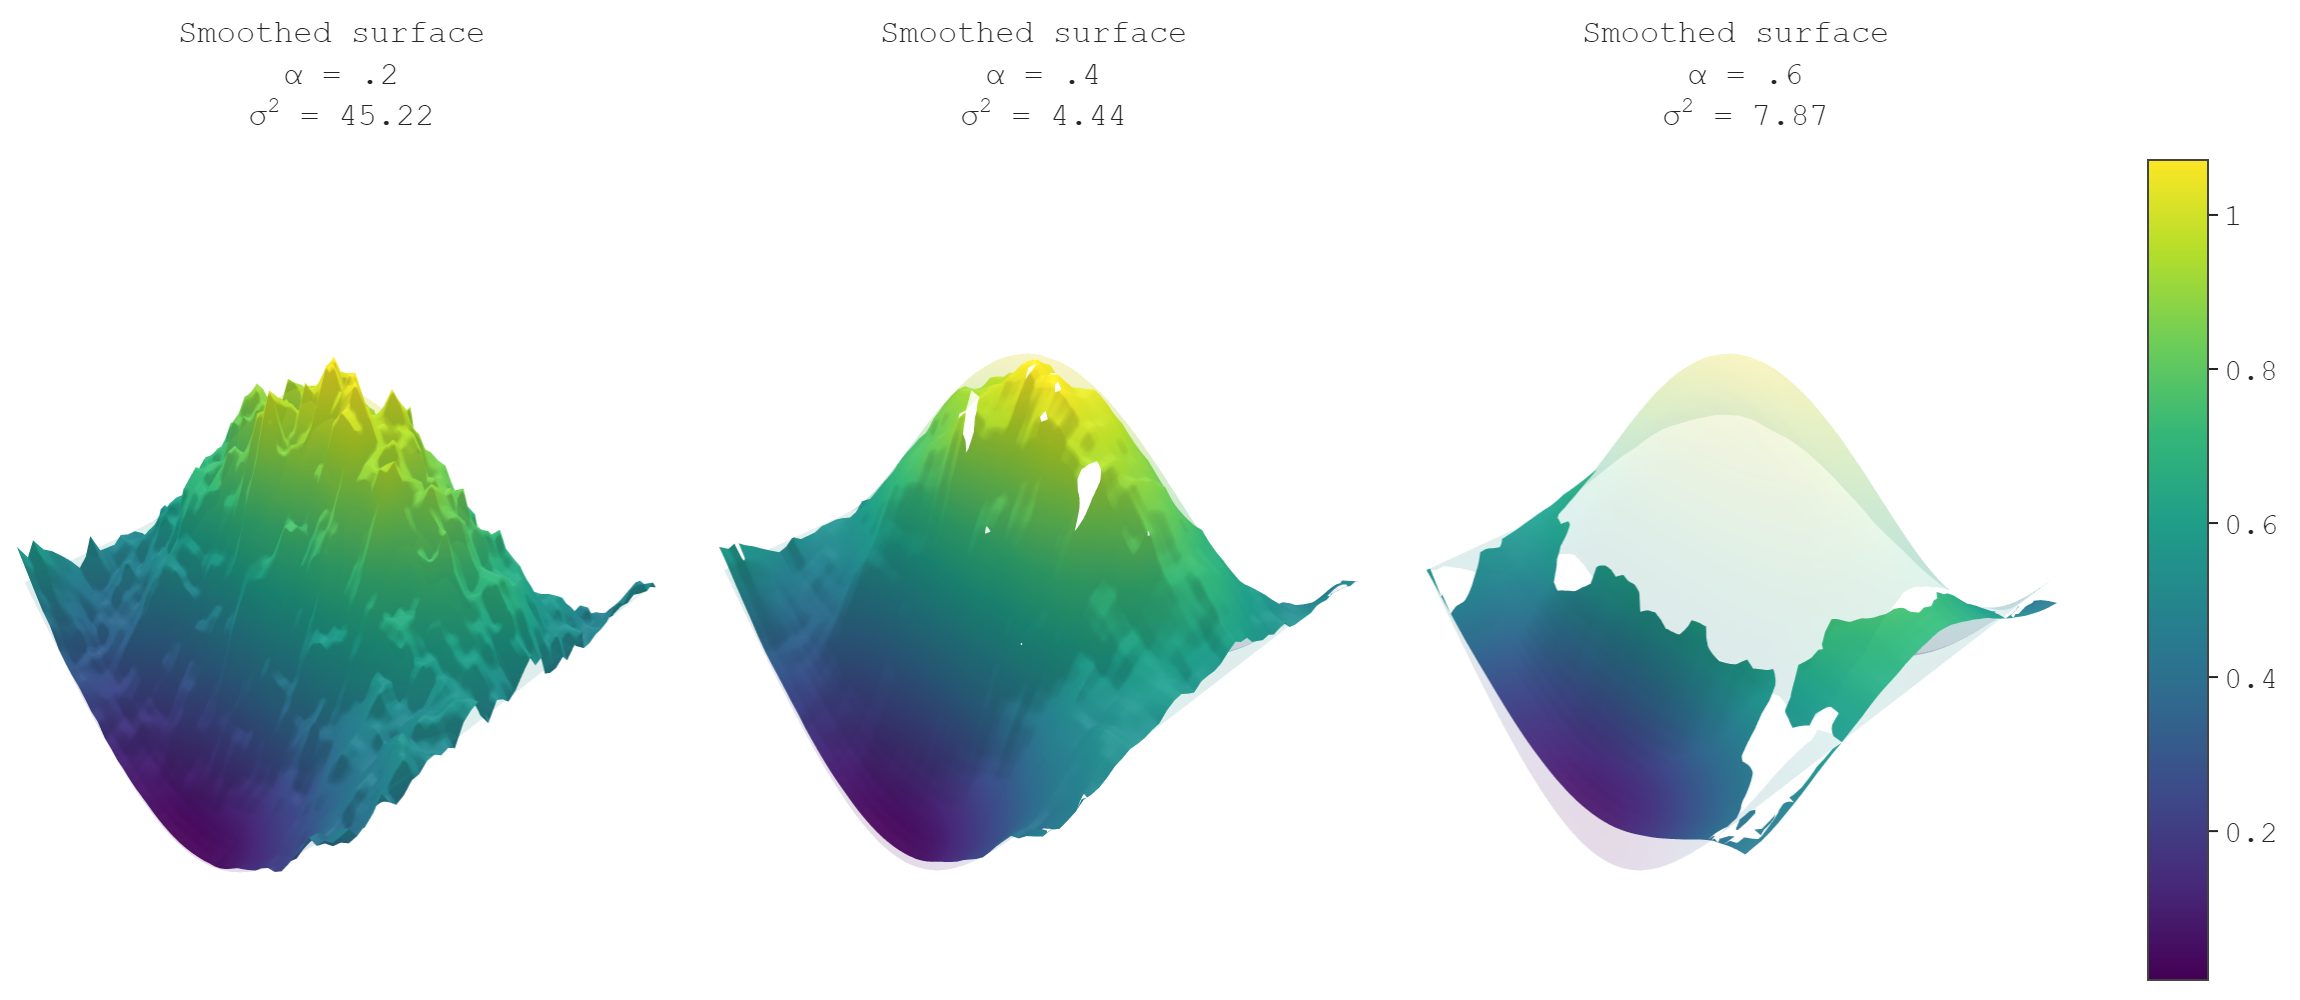

In [37]:
fig.write_html("Surface exp smoothing_alphas.html")
fig.write_image("Surface exp smoothing_alphas.png", format = 'png', scale = 2)
Image("Surface exp smoothing_alphas.png")

This graph also has some artifacts, so, please, check .html graph<br>
With alpha = 0.2 smoothed surface is too similar to "measurements" (noisy surface) <br>
alpha = 0.4 gives has the lowest variance out of tested values <br>
alpha = 0.6 produces too smooth surface. <br>


This issue is a common challenge associated with exponential smoothing techniques. When using high values of alpha, it results in a significant modification of peak heights. In contrast, moving average smoothing maintains similar variability indicator values to high alpha smoothing, preserving the degree of smoothness, particularly in relation to peak heights. However, when dealing with outliers rather than peaks, exponential smoothing is more effective in managing such data.